In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# Data preparation

In [2]:
train = pd.read_csv("cifar-10/trainLabels.csv")

In [3]:
train.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [4]:
X = train["id"]
Y = train["label"]
print("Training samples {}".format(X.shape))
print("Training labels {}".format(X.shape))

Training samples (50000,)
Training labels (50000,)


In [5]:
Y.value_counts()

frog          5000
cat           5000
ship          5000
bird          5000
automobile    5000
airplane      5000
dog           5000
horse         5000
deer          5000
truck         5000
Name: label, dtype: int64

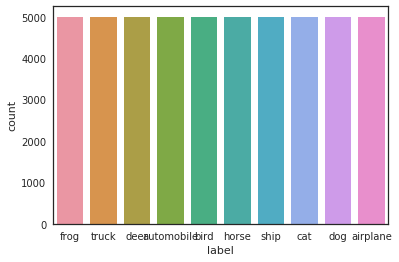

In [6]:
g = sns.countplot(Y)

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')

## Examples

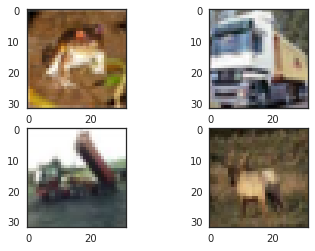

In [8]:
# Some examples
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_train[0]/ 255.0)
axarr[0,1].imshow(X_train[1]/ 255.0)
axarr[1,0].imshow(X_train[2]/ 255.0)
axarr[1,1].imshow(X_train[3]/ 255.0)

## Functions

In [9]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    X_train = x_train.astype('float32')
    X_test = x_test.astype('float32')
    return X_train, y_train, X_test, y_test

In [10]:
def labelencoding(y_train, y_val, y_test, nb_classes):
    Y_val = to_categorical(y_val, num_classes = nb_classes)
    Y_test = to_categorical(y_test, num_classes = nb_classes)
    Y_train = to_categorical(y_train.reshape(-1, 1), num_classes = nb_classes)
    return Y_train, Y_val, Y_test

In [11]:
def split_dataset(X_train, Y_train, reduce_dataset):

    # Set the random seed
    random_seed = 2

    if reduce_dataset:
        # 500 images per class
        X = []
        Y = []
        for i in range(CLASSES):
            idxs = np.where(Y_train.reshape(1,-1)[0] == i)[0]
            idx_ = list(np.random.choice(idxs, 500, replace=False))
            Y += idx_

        Y_train = Y_train[Y]
        X_train = X_train[Y]

    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)
    
    return X_train, X_val, Y_train, Y_val

In [12]:
def getOptimizer():
    # Define the optimizer
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    return optimizer

In [13]:
def plot_loss_acc(history):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.savefig('learningCurves.png')

In [14]:
def resize_images(X_train, resize_image):
    X = []
    for img in X_train:
        img_r = cv2.resize(img, (resize_image, resize_image))
        X.append(img_r)
    return np.array(X)

In [15]:
def train(reduce_dataset, model_mode, resize_image=None):

    X_train, Y_train, X_test, Y_test = load_data()
    
    X_train, X_val, Y_train, Y_val = split_dataset(X_train, Y_train, reduce_dataset)

    Y_train, Y_val, Y_test = labelencoding(Y_train, Y_val, Y_test, CLASSES)
    
    if resize_image != None:
        X_train = resize_images(X_train, resize_image)
        X_val = resize_images(X_val, resize_image)

    print("Training images: {}".format(X_train.shape))
    print("Training labels: {}".format(Y_train.shape))
    print("Validation images: {}".format(X_val.shape))
    print("Validation labels: {}".format(Y_val.shape))
    print("Testing images: {}".format(X_test.shape))
    print("Testing labels: {}".format(Y_test.shape))

    
    # mode must be one of the following options "ad-hoc" or "InceptionV3" 
    # model = getModel(mode="ad-hoc")
    model = getModel(mode=model_mode)

    print(model.summary())

    optimizer = getOptimizer()

    # Compile the model
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    
    os.makedirs("weights", exist_ok=True)
    checkPoint = ModelCheckpoint("weights/weights.{epoch:02d}-{val_acc:.2f}.hdf5", monitor='val_acc', save_weights_only=True)
    
    

    datagen_train = ImageDataGenerator(rescale=1./255)
    datagen_val = ImageDataGenerator(rescale=1./255)

    history = model.fit_generator(datagen_train.flow(X_train,Y_train, batch_size=BATCH_SIZE),
                              epochs = EPOCHS,
                              validation_data = datagen_val.flow(X_val, Y_val, batch_size=BATCH_SIZE),
                              steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                              validation_steps = X_val.shape[0] // BATCH_SIZE,
                              callbacks=[learning_rate_reduction, checkPoint])
    
    print(history.history)
    plot_loss_acc(history)

In [16]:
def test(resize_image, weights_path, model_mode):
    X_train, Y_train, X_test, Y_true = load_data()
    if resize_image != None:
        X_test = resize_images(X_test, resize_image)

    #model = getModel(mode="InceptionV3")
    model = getModel(mode=model_mode)

    model.load_weights(weights_path)

    Y_true = Y_true.reshape(1,-1)[0]
    print(Y_true.shape)
    
    datagen_test = ImageDataGenerator(rescale=1./255)
    Y_pred = model.predict_generator(datagen_test.flow(X_test))
    Y_pred = np.argmax(Y_pred, axis=1)
    print(Y_pred.shape)

    print("Accuracy: {}".format(accuracy_score(Y_true, Y_pred)))
    print("Recall: {}".format(recall_score(Y_true, Y_pred, average=None)))
    print("Precision: {}".format(precision_score(Y_true, Y_pred, average=None)))
    print("F1: {}".format(f1_score(Y_true, Y_pred, average=None)))